In [11]:
import os
import random
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

# Define Dataset Class
class VideoFrameDataset(Dataset):
    def __init__(self, data_dir, transform=None, sequence_length=10):
        """
        Args:
            data_dir (str): Directory containing 'original' and 'manipulated' subdirectories.
            transform (callable, optional): Transform to be applied on frames.
            sequence_length (int): Number of frames per video sequence.
        """
        self.data_dir = data_dir
        self.transform = transform
        self.sequence_length = sequence_length
        self.classes = {"original": 0, "manipulated": 1}
        self.data = []

        for cls, label in self.classes.items():
            cls_path = os.path.join(data_dir, cls)
            videos = os.listdir(cls_path)
            for video in videos:
                video_path = os.path.join(cls_path, video)
                frames = sorted(os.listdir(video_path))
                if len(frames) >= sequence_length:
                    self.data.append((video_path, label, frames))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        video_path, label, frames = self.data[idx]
        sequence = []

        # Select a fixed number of frames
        selected_frames = frames[:self.sequence_length]

        for frame in selected_frames:
            frame_path = os.path.join(video_path, frame)
            image = Image.open(frame_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            sequence.append(image)

        sequence = torch.stack(sequence)
        return sequence, label

# Data Loading and Splitting
def get_data_loaders(data_dir, sequence_length=10, batch_size=8, val_split=0.2):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    dataset = VideoFrameDataset(data_dir=data_dir, transform=transform, sequence_length=sequence_length)

    val_size = int(len(dataset) * val_split)
    train_size = len(dataset) - val_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

# Model Definition
class EfficientNetGRU(nn.Module):
    def __init__(self, sequence_length=10, num_classes=2):
        super(EfficientNetGRU, self).__init__()
        self.sequence_length = sequence_length

        # EfficientNet Backbone
        self.efficientnet = models.efficientnet_b0(pretrained=True)
        self.efficientnet_features = nn.Sequential(
            *list(self.efficientnet.children())[:-2]
        )
        feature_size = self.efficientnet.classifier[1].in_features

        # GRU Layer
        self.gru = nn.GRU(feature_size, hidden_size=128, num_layers=2, batch_first=True, bidirectional=True)

        # Fully Connected Layer
        self.fc = nn.Linear(128 * 2, num_classes)

    def forward(self, x):
        batch_size, seq_len, c, h, w = x.size()
        assert seq_len == self.sequence_length, "Sequence length mismatch!"

        # Extract features frame-by-frame
        features = []
        for i in range(seq_len):
            frame_features = self.efficientnet_features(x[:, i])
            frame_features = frame_features.mean([2, 3])  # Global average pooling
            features.append(frame_features)

        features = torch.stack(features, dim=1)

        # GRU processing
        _, hidden = self.gru(features)
        hidden = torch.cat([hidden[-2], hidden[-1]], dim=1)

        # Classification
        output = self.fc(hidden)
        return output

# Training Loop
def train_model(model, train_loader, criterion, optimizer, num_epochs, device):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        y_true, y_pred = [], []

        for sequences, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):
            sequences, labels = sequences.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(outputs.argmax(dim=1).cpu().numpy())

        train_acc = accuracy_score(y_true, y_pred)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}, Accuracy: {train_acc:.4f}")

# Evaluation Loop
def evaluate_model(model, val_loader, device):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for sequences, labels in tqdm(val_loader, desc="Validation"):
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(outputs.argmax(dim=1).cpu().numpy())

    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=["original", "manipulated"]))

# Main Script
if __name__ == "__main__":
    # Hyperparameters
    sequence_length = 10
    batch_size = 8
    num_epochs = 5
    learning_rate = 1e-4
    val_split = 0.2

    # Dataset directory (contains 'original' and 'manipulated' subfolders)
    data_dir = "cropped_faces_big"

    # Device Configuration
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Get Data Loaders
    train_loader, val_loader = get_data_loaders(data_dir, sequence_length=sequence_length, batch_size=batch_size, val_split=val_split)

    # Initialize Model, Criterion, Optimizer
    model = EfficientNetGRU(sequence_length=sequence_length)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train and Evaluate
    train_model(model, train_loader, criterion, optimizer, num_epochs, device)
    evaluate_model(model, val_loader, device)


C:\Enviroment\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Enviroment\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\Runmay Shirsat/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:06<00:00, 3.18MB/s]
Epoch 1: 100%|██████████| 63/63 [06:27<00:00,  6.15s/it]


Epoch 1/5, Loss: 0.6015, Accuracy: 0.6821


Epoch 2: 100%|██████████| 63/63 [06:06<00:00,  5.81s/it]


Epoch 2/5, Loss: 0.3820, Accuracy: 0.8410


Epoch 3: 100%|██████████| 63/63 [06:13<00:00,  5.93s/it]


Epoch 3/5, Loss: 0.3160, Accuracy: 0.8692


Epoch 4: 100%|██████████| 63/63 [05:57<00:00,  5.68s/it]


Epoch 4/5, Loss: 0.1779, Accuracy: 0.9376


Epoch 5: 100%|██████████| 63/63 [05:56<00:00,  5.66s/it]


Epoch 5/5, Loss: 0.1629, Accuracy: 0.9416


Validation: 100%|██████████| 16/16 [00:22<00:00,  1.42s/it]

Classification Report:
              precision    recall  f1-score   support

    original       0.89      0.81      0.85        59
 manipulated       0.84      0.91      0.87        65

    accuracy                           0.86       124
   macro avg       0.87      0.86      0.86       124
weighted avg       0.86      0.86      0.86       124



Validation: 100%|██████████| 16/16 [00:22<00:00,  1.38s/it]


Classification Report:
              precision    recall  f1-score   support

    original       0.89      0.81      0.85        59
 manipulated       0.84      0.91      0.87        65

    accuracy                           0.86       124
   macro avg       0.87      0.86      0.86       124
weighted avg       0.86      0.86      0.86       124



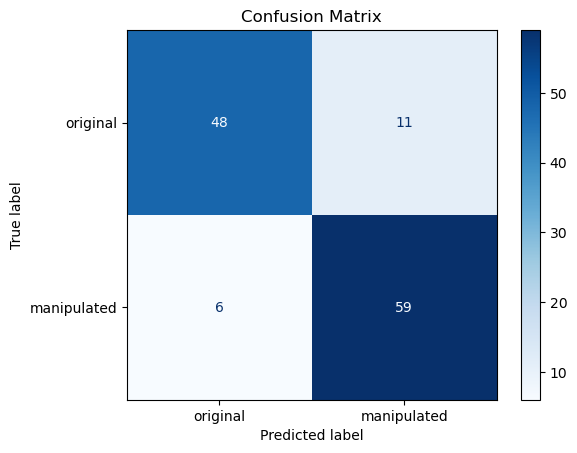

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Plot confusion matrix using sklearn's ConfusionMatrixDisplay.

    Args:
        y_true (list or np.array): Ground truth labels.
        y_pred (list or np.array): Predicted labels.
        class_names (list): List of class names (e.g., ["original", "manipulated"]).
    """
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title("Confusion Matrix")
    plt.show()

# After evaluating the model
def evaluate_with_confusion_matrix(model, val_loader, device, class_names):
    """
    Evaluate the model and generate the confusion matrix.

    Args:
        model (nn.Module): Trained model.
        val_loader (DataLoader): Validation DataLoader.
        device (torch.device): Computation device (CPU or GPU).
        class_names (list): List of class names.
    """
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for sequences, labels in tqdm(val_loader, desc="Validation"):
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(outputs.argmax(dim=1).cpu().numpy())

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Plot confusion matrix
    plot_confusion_matrix(y_true, y_pred, class_names)

# Example Usage
if __name__ == "__main__":
    # Assuming 'model', 'val_loader', and 'device' are already defined
    class_names = ["original", "manipulated"]
    evaluate_with_confusion_matrix(model, val_loader, device, class_names)


In [19]:
# Save the trained model
def save_model(model, file_path):
    torch.save(model.state_dict(), file_path)
    print(f"Model saved to {file_path}")

# Main Script (After Training)
if __name__ == "__main__":
    # Hyperparameters and setup
    sequence_length = 10
    batch_size = 8
    num_epochs = 5
    learning_rate = 1e-4
    val_split = 0.2

    # Dataset directory (contains 'original' and 'manipulated' subfolders)
    data_dir = "cropped_faces_big"

    # Device Configuration
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Get Data Loaders
    train_loader, val_loader = get_data_loaders(data_dir, sequence_length=sequence_length, batch_size=batch_size, val_split=val_split)

    # Initialize Model, Criterion, Optimizer
    model = EfficientNetGRU(sequence_length=sequence_length)
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    train_model(model, train_loader, criterion, optimizer, num_epochs, device)

    # Evaluate the model
    evaluate_model(model, val_loader, device)

    # Save the model after training
    save_model(model, "EfficientNet-GRU.pth")


C:\Enviroment\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Enviroment\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


TypeError: train_model() missing 1 required positional argument: 'device'

In [17]:
import os
import random
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

# Define Dataset Class
class VideoFrameDataset(Dataset):
    def __init__(self, data_dir, transform=None, sequence_length=10):
        """
        Args:
            data_dir (str): Directory containing 'original' and 'manipulated' subdirectories.
            transform (callable, optional): Transform to be applied on frames.
            sequence_length (int): Number of frames per video sequence.
        """
        self.data_dir = data_dir
        self.transform = transform
        self.sequence_length = sequence_length
        self.classes = {"original": 0, "manipulated": 1}
        self.data = []

        for cls, label in self.classes.items():
            cls_path = os.path.join(data_dir, cls)
            videos = os.listdir(cls_path)
            for video in videos:
                video_path = os.path.join(cls_path, video)
                frames = sorted(os.listdir(video_path))
                if len(frames) >= sequence_length:
                    self.data.append((video_path, label, frames))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        video_path, label, frames = self.data[idx]
        sequence = []

        # Select a fixed number of frames
        selected_frames = frames[:self.sequence_length]

        for frame in selected_frames:
            frame_path = os.path.join(video_path, frame)
            image = Image.open(frame_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            sequence.append(image)

        sequence = torch.stack(sequence)
        return sequence, label

# Data Loading and Splitting
def get_data_loaders(data_dir, sequence_length=10, batch_size=8, val_split=0.2):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    dataset = VideoFrameDataset(data_dir=data_dir, transform=transform, sequence_length=sequence_length)

    val_size = int(len(dataset) * val_split)
    train_size = len(dataset) - val_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

# Model Definition
class EfficientNetGRU(nn.Module):
    def __init__(self, sequence_length=10, num_classes=2):
        super(EfficientNetGRU, self).__init__()
        self.sequence_length = sequence_length

        # EfficientNet Backbone
        self.efficientnet = models.efficientnet_b0(pretrained=True)
        self.efficientnet_features = nn.Sequential(
            *list(self.efficientnet.children())[:-2]
        )
        feature_size = self.efficientnet.classifier[1].in_features

        # GRU Layer
        self.gru = nn.GRU(feature_size, hidden_size=128, num_layers=2, batch_first=True, bidirectional=True)

        # Fully Connected Layer
        self.fc = nn.Linear(128 * 2, num_classes)

    def forward(self, x):
        batch_size, seq_len, c, h, w = x.size()
        assert seq_len == self.sequence_length, "Sequence length mismatch!"

        # Extract features frame-by-frame
        features = []
        for i in range(seq_len):
            frame_features = self.efficientnet_features(x[:, i])
            frame_features = frame_features.mean([2, 3])  # Global average pooling
            features.append(frame_features)

        features = torch.stack(features, dim=1)

        # GRU processing
        _, hidden = self.gru(features)
        hidden = torch.cat([hidden[-2], hidden[-1]], dim=1)

        # Classification
        output = self.fc(hidden)
        return output

# Training Loop with Validation Accuracy Calculation and Model Saving
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, save_dir="models"):
    model.to(device)
    
    best_val_acc = 0.0  # Track best validation accuracy
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        y_true_train, y_pred_train = [], []

        for sequences, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):
            sequences, labels = sequences.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            y_true_train.extend(labels.cpu().numpy())
            y_pred_train.extend(outputs.argmax(dim=1).cpu().numpy())

        train_acc = accuracy_score(y_true_train, y_pred_train)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}, Training Accuracy: {train_acc:.4f}")

        # Validation phase
        val_acc = evaluate_accuracy(model, val_loader, device)
        print(f"Validation Accuracy after Epoch {epoch + 1}: {val_acc:.4f}")

        # Save the model if validation accuracy improves
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            model_path = os.path.join(save_dir, f"best_model_epoch_{epoch + 1}.pth")
            torch.save(model.state_dict(), model_path)
            print(f"Model saved at epoch {epoch + 1} with validation accuracy {val_acc:.4f}")

# Evaluation Accuracy Calculation
def evaluate_accuracy(model, val_loader, device):
    model.eval()
    y_true_val, y_pred_val = [], []

    with torch.no_grad():
        for sequences, labels in tqdm(val_loader, desc="Validation"):
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)

            y_true_val.extend(labels.cpu().numpy())
            y_pred_val.extend(outputs.argmax(dim=1).cpu().numpy())

    val_acc = accuracy_score(y_true_val, y_pred_val)
    return val_acc

# Main Script
if __name__ == "__main__":
    # Hyperparameters
    sequence_length = 10
    batch_size = 8
    num_epochs = 10
    learning_rate = 1e-4
    val_split = 0.2

    # Dataset directory (contains 'original' and 'manipulated' subfolders)
    data_dir = "cropped_faces_big"

    # Device Configuration
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Get Data Loaders
    train_loader, val_loader = get_data_loaders(data_dir, sequence_length=sequence_length, batch_size=batch_size, val_split=val_split)

    # Initialize Model, Criterion, Optimizer
    model = EfficientNetGRU(sequence_length=sequence_length)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train and Evaluate
    train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)
    # Final evaluation of the model
    evaluate_model(model, val_loader, device)


Epoch 1: 100%|██████████| 63/63 [05:01<00:00,  4.78s/it]


Epoch 1/10, Loss: 0.6227, Training Accuracy: 0.6499


Validation: 100%|██████████| 16/16 [00:20<00:00,  1.26s/it]


Validation Accuracy after Epoch 1: 0.7339
Model saved at epoch 1 with validation accuracy 0.7339


Epoch 2: 100%|██████████| 63/63 [05:32<00:00,  5.27s/it]


Epoch 2/10, Loss: 0.3881, Training Accuracy: 0.8350


Validation: 100%|██████████| 16/16 [00:20<00:00,  1.30s/it]


Validation Accuracy after Epoch 2: 0.7903
Model saved at epoch 2 with validation accuracy 0.7903


Epoch 3: 100%|██████████| 63/63 [05:16<00:00,  5.03s/it]


Epoch 3/10, Loss: 0.2576, Training Accuracy: 0.8813


Validation: 100%|██████████| 16/16 [00:20<00:00,  1.29s/it]


Validation Accuracy after Epoch 3: 0.7177


Epoch 4: 100%|██████████| 63/63 [05:20<00:00,  5.08s/it]


Epoch 4/10, Loss: 0.1911, Training Accuracy: 0.9316


Validation: 100%|██████████| 16/16 [00:20<00:00,  1.29s/it]


Validation Accuracy after Epoch 4: 0.6935


Epoch 5: 100%|██████████| 63/63 [05:13<00:00,  4.98s/it]


Epoch 5/10, Loss: 0.1160, Training Accuracy: 0.9638


Validation: 100%|██████████| 16/16 [00:21<00:00,  1.32s/it]


Validation Accuracy after Epoch 5: 0.7339


Epoch 6: 100%|██████████| 63/63 [05:17<00:00,  5.04s/it]


Epoch 6/10, Loss: 0.1424, Training Accuracy: 0.9577


Validation: 100%|██████████| 16/16 [00:20<00:00,  1.29s/it]


Validation Accuracy after Epoch 6: 0.8629
Model saved at epoch 6 with validation accuracy 0.8629


Epoch 7: 100%|██████████| 63/63 [05:13<00:00,  4.98s/it]


Epoch 7/10, Loss: 0.1627, Training Accuracy: 0.9497


Validation: 100%|██████████| 16/16 [00:20<00:00,  1.28s/it]


Validation Accuracy after Epoch 7: 0.7177


Epoch 8: 100%|██████████| 63/63 [05:09<00:00,  4.91s/it]


Epoch 8/10, Loss: 0.1000, Training Accuracy: 0.9577


Validation: 100%|██████████| 16/16 [00:19<00:00,  1.23s/it]


Validation Accuracy after Epoch 8: 0.8306


Epoch 9: 100%|██████████| 63/63 [05:00<00:00,  4.77s/it]


Epoch 9/10, Loss: 0.0762, Training Accuracy: 0.9718


Validation: 100%|██████████| 16/16 [00:19<00:00,  1.22s/it]


Validation Accuracy after Epoch 9: 0.9032
Model saved at epoch 9 with validation accuracy 0.9032


Epoch 10: 100%|██████████| 63/63 [04:59<00:00,  4.76s/it]


Epoch 10/10, Loss: 0.0892, Training Accuracy: 0.9718


Validation: 100%|██████████| 16/16 [00:19<00:00,  1.23s/it]


Validation Accuracy after Epoch 10: 0.5565


Validation: 100%|██████████| 16/16 [00:19<00:00,  1.19s/it]

Classification Report:
              precision    recall  f1-score   support

    original       0.51      0.90      0.65        58
 manipulated       0.74      0.26      0.38        66

    accuracy                           0.56       124
   macro avg       0.63      0.58      0.52       124
weighted avg       0.63      0.56      0.51       124

Confusion Matrix:
[[52  6]
 [49 17]]


Validation: 100%|██████████| 16/16 [00:18<00:00,  1.17s/it]


Classification Report:
              precision    recall  f1-score   support

    original       0.51      0.90      0.65        58
 manipulated       0.74      0.26      0.38        66

    accuracy                           0.56       124
   macro avg       0.63      0.58      0.52       124
weighted avg       0.63      0.56      0.51       124



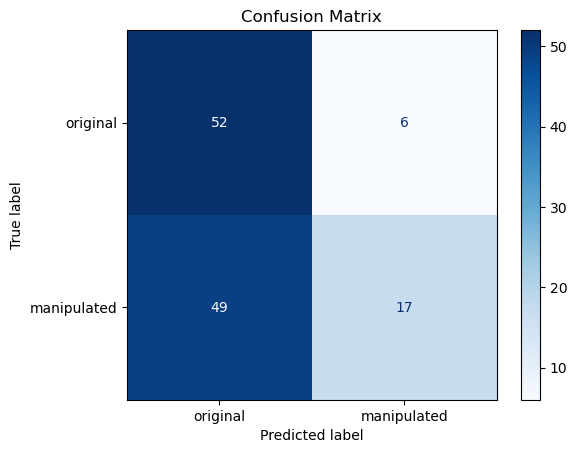

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Plot confusion matrix using sklearn's ConfusionMatrixDisplay.

    Args:
        y_true (list or np.array): Ground truth labels.
        y_pred (list or np.array): Predicted labels.
        class_names (list): List of class names (e.g., ["original", "manipulated"]).
    """
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title("Confusion Matrix")
    plt.show()

# After evaluating the model
def evaluate_with_confusion_matrix(model, val_loader, device, class_names):
    """
    Evaluate the model and generate the confusion matrix.

    Args:
        model (nn.Module): Trained model.
        val_loader (DataLoader): Validation DataLoader.
        device (torch.device): Computation device (CPU or GPU).
        class_names (list): List of class names.
    """
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for sequences, labels in tqdm(val_loader, desc="Validation"):
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(outputs.argmax(dim=1).cpu().numpy())

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Plot confusion matrix
    plot_confusion_matrix(y_true, y_pred, class_names)

# Example Usage
if __name__ == "__main__":
    # Assuming 'model', 'val_loader', and 'device' are already defined
    class_names = ["original", "manipulated"]
    evaluate_with_confusion_matrix(model, val_loader, device, class_names)


In [1]:
import os
import random
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

# Define Dataset Class
class VideoFrameDataset(Dataset):
    def __init__(self, data_dir, transform=None, sequence_length=10):
        """
        Args:
            data_dir (str): Directory containing 'original' and 'manipulated' subdirectories.
            transform (callable, optional): Transform to be applied on frames.
            sequence_length (int): Number of frames per video sequence.
        """
        self.data_dir = data_dir
        self.transform = transform
        self.sequence_length = sequence_length
        self.classes = {"original": 0, "manipulated": 1}
        self.data = []

        for cls, label in self.classes.items():
            cls_path = os.path.join(data_dir, cls)
            videos = os.listdir(cls_path)
            for video in videos:
                video_path = os.path.join(cls_path, video)
                frames = sorted(os.listdir(video_path))
                if len(frames) >= sequence_length:
                    self.data.append((video_path, label, frames))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        video_path, label, frames = self.data[idx]
        sequence = []

        # Select a fixed number of frames
        selected_frames = frames[:self.sequence_length]

        for frame in selected_frames:
            frame_path = os.path.join(video_path, frame)
            image = Image.open(frame_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            sequence.append(image)

        sequence = torch.stack(sequence)
        return sequence, label

# Data Loading and Splitting
def get_data_loaders(data_dir, sequence_length=10, batch_size=8, val_split=0.2):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    dataset = VideoFrameDataset(data_dir=data_dir, transform=transform, sequence_length=sequence_length)

    val_size = int(len(dataset) * val_split)
    train_size = len(dataset) - val_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

# Model Definition
class EfficientNetGRU(nn.Module):
    def __init__(self, sequence_length=10, num_classes=2):
        super(EfficientNetGRU, self).__init__()
        self.sequence_length = sequence_length

        # EfficientNet Backbone
        self.efficientnet = models.efficientnet_b0(pretrained=True)
        self.efficientnet_features = nn.Sequential(
            *list(self.efficientnet.children())[:-2]
        )
        feature_size = self.efficientnet.classifier[1].in_features

        # GRU Layer
        self.gru = nn.GRU(feature_size, hidden_size=128, num_layers=2, batch_first=True, bidirectional=True)

        # Fully Connected Layer
        self.fc = nn.Linear(128 * 2, num_classes)

    def forward(self, x):
        batch_size, seq_len, c, h, w = x.size()
        assert seq_len == self.sequence_length, "Sequence length mismatch!"

        # Extract features frame-by-frame
        features = []
        for i in range(seq_len):
            frame_features = self.efficientnet_features(x[:, i])
            frame_features = frame_features.mean([2, 3])  # Global average pooling
            features.append(frame_features)

        features = torch.stack(features, dim=1)

        # GRU processing
        _, hidden = self.gru(features)
        hidden = torch.cat([hidden[-2], hidden[-1]], dim=1)

        # Classification
        output = self.fc(hidden)
        return output

# Training Loop
def train_model(model, train_loader, criterion, optimizer, num_epochs, device):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        y_true, y_pred = [], []

        for sequences, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):
            sequences, labels = sequences.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(outputs.argmax(dim=1).cpu().numpy())

        train_acc = accuracy_score(y_true, y_pred)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}, Accuracy: {train_acc:.4f}")

# Evaluation Loop
def evaluate_model(model, val_loader, device):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for sequences, labels in tqdm(val_loader, desc="Validation"):
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(outputs.argmax(dim=1).cpu().numpy())

    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=["original", "manipulated"]))

# Save the trained model
def save_model(model, file_path):
    torch.save(model.state_dict(), file_path)
    print(f"Model saved to {file_path}")

# Main Script (After Training)
if __name__ == "__main__":
    # Hyperparameters and setup
    sequence_length = 10
    batch_size = 8
    num_epochs = 5
    learning_rate = 1e-4
    val_split = 0.2

    # Dataset directory (contains 'original' and 'manipulated' subfolders)
    data_dir = "cropped_faces_big"

    # Device Configuration
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Get Data Loaders
    train_loader, val_loader = get_data_loaders(data_dir, sequence_length=sequence_length, batch_size=batch_size, val_split=val_split)

    # Initialize Model, Criterion, Optimizer
    model = EfficientNetGRU(sequence_length=sequence_length)
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    train_model(model, train_loader, criterion, optimizer, num_epochs, device)

    # Evaluate the model
    evaluate_model(model, val_loader, device)

    # Save the model after training
    save_model(model, "EfficientNet-GRU.pth")


C:\Enviroment\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Enviroment\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1: 100%|██████████| 63/63 [06:27<00:00,  6.14s/it]


Epoch 1/5, Loss: 0.6285, Accuracy: 0.6419


Epoch 2: 100%|██████████| 63/63 [05:30<00:00,  5.25s/it]


Epoch 2/5, Loss: 0.3706, Accuracy: 0.8451


Epoch 3: 100%|██████████| 63/63 [05:33<00:00,  5.29s/it]


Epoch 3/5, Loss: 0.2047, Accuracy: 0.9195


Epoch 4: 100%|██████████| 63/63 [05:44<00:00,  5.46s/it]


Epoch 4/5, Loss: 0.1709, Accuracy: 0.9336


Epoch 5: 100%|██████████| 63/63 [05:28<00:00,  5.22s/it]


Epoch 5/5, Loss: 0.2127, Accuracy: 0.9135


Validation: 100%|██████████| 16/16 [00:20<00:00,  1.31s/it]

Classification Report:
              precision    recall  f1-score   support

    original       0.74      0.93      0.82        60
 manipulated       0.92      0.69      0.79        64

    accuracy                           0.81       124
   macro avg       0.83      0.81      0.80       124
weighted avg       0.83      0.81      0.80       124

Model saved to EfficientNet-GRU.pth


Validation: 100%|██████████| 16/16 [00:18<00:00,  1.18s/it]


Classification Report:
              precision    recall  f1-score   support

    original       0.74      0.93      0.82        60
 manipulated       0.92      0.69      0.79        64

    accuracy                           0.81       124
   macro avg       0.83      0.81      0.80       124
weighted avg       0.83      0.81      0.80       124



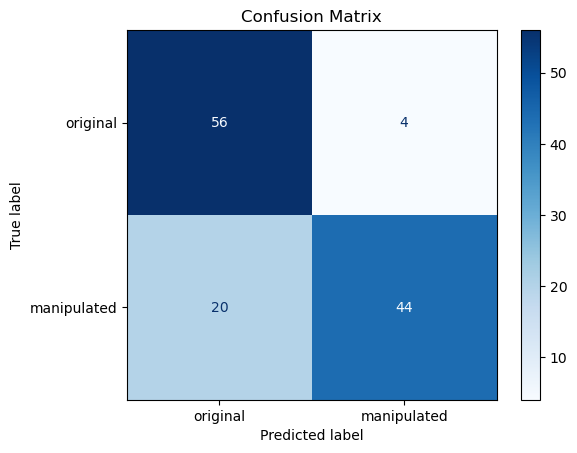

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Plot confusion matrix using sklearn's ConfusionMatrixDisplay.

    Args:
        y_true (list or np.array): Ground truth labels.
        y_pred (list or np.array): Predicted labels.
        class_names (list): List of class names (e.g., ["original", "manipulated"]).
    """
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title("Confusion Matrix")
    plt.show()

# After evaluating the model
def evaluate_with_confusion_matrix(model, val_loader, device, class_names):
    """
    Evaluate the model and generate the confusion matrix.

    Args:
        model (nn.Module): Trained model.
        val_loader (DataLoader): Validation DataLoader.
        device (torch.device): Computation device (CPU or GPU).
        class_names (list): List of class names.
    """
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for sequences, labels in tqdm(val_loader, desc="Validation"):
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(outputs.argmax(dim=1).cpu().numpy())

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Plot confusion matrix
    plot_confusion_matrix(y_true, y_pred, class_names)

# Example Usage
if __name__ == "__main__":
    # Assuming 'model', 'val_loader', and 'device' are already defined
    class_names = ["original", "manipulated"]
    evaluate_with_confusion_matrix(model, val_loader, device, class_names)


In [1]:
import os
import random
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

# Define Dataset Class
class VideoFrameDataset(Dataset):
    def __init__(self, data_dir, transform=None, sequence_length=10):
        """
        Args:
            data_dir (str): Directory containing 'original' and 'manipulated' subdirectories.
            transform (callable, optional): Transform to be applied on frames.
            sequence_length (int): Number of frames per video sequence.
        """
        self.data_dir = data_dir
        self.transform = transform
        self.sequence_length = sequence_length
        self.classes = {"original": 0, "manipulated": 1}
        self.data = []

        for cls, label in self.classes.items():
            cls_path = os.path.join(data_dir, cls)
            videos = os.listdir(cls_path)
            for video in videos:
                video_path = os.path.join(cls_path, video)
                frames = sorted(os.listdir(video_path))
                if len(frames) >= sequence_length:
                    self.data.append((video_path, label, frames))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        video_path, label, frames = self.data[idx]
        sequence = []

        # Select a fixed number of frames
        selected_frames = frames[:self.sequence_length]

        for frame in selected_frames:
            frame_path = os.path.join(video_path, frame)
            image = Image.open(frame_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            sequence.append(image)

        sequence = torch.stack(sequence)
        return sequence, label

# Data Loading and Splitting
def get_data_loaders(data_dir, sequence_length=10, batch_size=8, val_split=0.2):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    dataset = VideoFrameDataset(data_dir=data_dir, transform=transform, sequence_length=sequence_length)

    val_size = int(len(dataset) * val_split)
    train_size = len(dataset) - val_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

# Model Definition
class EfficientNetGRU(nn.Module):
    def __init__(self, sequence_length=10, num_classes=2):
        super(EfficientNetGRU, self).__init__()
        self.sequence_length = sequence_length

        # EfficientNet Backbone
        self.efficientnet = models.efficientnet_b0(pretrained=True)
        self.efficientnet_features = nn.Sequential(
            *list(self.efficientnet.children())[:-2]
        )
        feature_size = self.efficientnet.classifier[1].in_features

        # GRU Layer
        self.gru = nn.GRU(feature_size, hidden_size=128, num_layers=2, batch_first=True, bidirectional=True)

        # Fully Connected Layer
        self.fc = nn.Linear(128 * 2, num_classes)

    def forward(self, x):
        batch_size, seq_len, c, h, w = x.size()
        assert seq_len == self.sequence_length, "Sequence length mismatch!"

        # Extract features frame-by-frame
        features = []
        for i in range(seq_len):
            frame_features = self.efficientnet_features(x[:, i])
            frame_features = frame_features.mean([2, 3])  # Global average pooling
            features.append(frame_features)

        features = torch.stack(features, dim=1)

        # GRU processing
        _, hidden = self.gru(features)
        hidden = torch.cat([hidden[-2], hidden[-1]], dim=1)

        # Classification
        output = self.fc(hidden)
        return output

# Training Loop with Validation Accuracy Calculation and Model Saving
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, save_dir="models"):
    model.to(device)
    
    best_val_acc = 0.0  # Track best validation accuracy
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        y_true_train, y_pred_train = [], []

        for sequences, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):
            sequences, labels = sequences.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            y_true_train.extend(labels.cpu().numpy())
            y_pred_train.extend(outputs.argmax(dim=1).cpu().numpy())

        train_acc = accuracy_score(y_true_train, y_pred_train)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}, Training Accuracy: {train_acc:.4f}")

        # Validation phase
        val_acc = evaluate_accuracy(model, val_loader, device)
        print(f"Validation Accuracy after Epoch {epoch + 1}: {val_acc:.4f}")

        # Save the model if validation accuracy improves
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            model_path = os.path.join(save_dir, f"best_model_epoch_{epoch + 1}.pth")
            torch.save(model.state_dict(), model_path)
            print(f"Model saved at epoch {epoch + 1} with validation accuracy {val_acc:.4f}")

# Evaluation Accuracy Calculation
def evaluate_accuracy(model, val_loader, device):
    model.eval()
    y_true_val, y_pred_val = [], []

    with torch.no_grad():
        for sequences, labels in tqdm(val_loader, desc="Validation"):
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)

            y_true_val.extend(labels.cpu().numpy())
            y_pred_val.extend(outputs.argmax(dim=1).cpu().numpy())

    val_acc = accuracy_score(y_true_val, y_pred_val)
    return val_acc

# Main Script
if __name__ == "__main__":
    # Hyperparameters
    sequence_length = 10
    batch_size = 8
    num_epochs = 5
    learning_rate = 1e-4
    val_split = 0.2

    # Dataset directory (contains 'original' and 'manipulated' subfolders)
    data_dir = "cropped_faces_big/TRAIN"

    # Device Configuration
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Get Data Loaders
    train_loader, val_loader = get_data_loaders(data_dir, sequence_length=sequence_length, batch_size=batch_size, val_split=val_split)

    # Initialize Model, Criterion, Optimizer
    model = EfficientNetGRU(sequence_length=sequence_length)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train and Evaluate
    train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)
    # Final evaluation of the model
    evaluate_model(model, val_loader, device)


C:\Enviroment\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Enviroment\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1: 100%|██████████| 53/53 [04:45<00:00,  5.39s/it]


Epoch 1/5, Loss: 0.6279, Training Accuracy: 0.6321


Validation: 100%|██████████| 14/14 [00:17<00:00,  1.28s/it]


Validation Accuracy after Epoch 1: 0.8476
Model saved at epoch 1 with validation accuracy 0.8476


Epoch 2: 100%|██████████| 53/53 [04:39<00:00,  5.27s/it]


Epoch 2/5, Loss: 0.4180, Training Accuracy: 0.8184


Validation: 100%|██████████| 14/14 [00:17<00:00,  1.25s/it]


Validation Accuracy after Epoch 2: 0.8762
Model saved at epoch 2 with validation accuracy 0.8762


Epoch 3: 100%|██████████| 53/53 [04:43<00:00,  5.35s/it]


Epoch 3/5, Loss: 0.2382, Training Accuracy: 0.9080


Validation: 100%|██████████| 14/14 [00:18<00:00,  1.32s/it]


Validation Accuracy after Epoch 3: 0.8857
Model saved at epoch 3 with validation accuracy 0.8857


Epoch 4: 100%|██████████| 53/53 [04:39<00:00,  5.27s/it]


Epoch 4/5, Loss: 0.1833, Training Accuracy: 0.9175


Validation: 100%|██████████| 14/14 [00:17<00:00,  1.24s/it]


Validation Accuracy after Epoch 4: 0.8190


Epoch 5: 100%|██████████| 53/53 [04:39<00:00,  5.28s/it]


Epoch 5/5, Loss: 0.1516, Training Accuracy: 0.9387


Validation: 100%|██████████| 14/14 [00:18<00:00,  1.35s/it]


Validation Accuracy after Epoch 5: 0.8857


NameError: name 'evaluate_model' is not defined

Validation: 100%|██████████| 14/14 [00:16<00:00,  1.17s/it]


Classification Report:
              precision    recall  f1-score   support

    original       0.90      0.87      0.88        52
 manipulated       0.87      0.91      0.89        53

    accuracy                           0.89       105
   macro avg       0.89      0.89      0.89       105
weighted avg       0.89      0.89      0.89       105



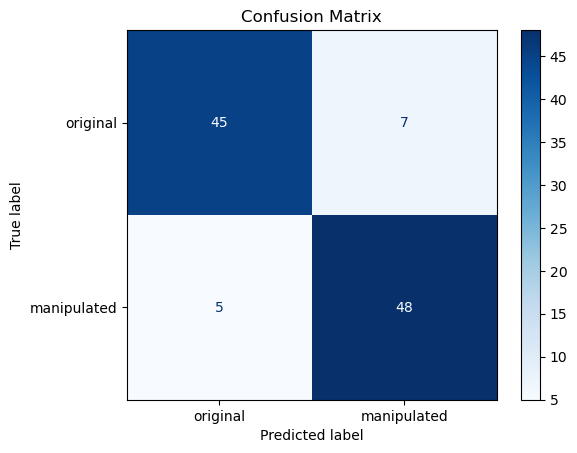

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Plot confusion matrix using sklearn's ConfusionMatrixDisplay.

    Args:
        y_true (list or np.array): Ground truth labels.
        y_pred (list or np.array): Predicted labels.
        class_names (list): List of class names (e.g., ["original", "manipulated"]).
    """
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title("Confusion Matrix")
    plt.show()

# After evaluating the model
def evaluate_with_confusion_matrix(model, val_loader, device, class_names):
    """
    Evaluate the model and generate the confusion matrix.

    Args:
        model (nn.Module): Trained model.
        val_loader (DataLoader): Validation DataLoader.
        device (torch.device): Computation device (CPU or GPU).
        class_names (list): List of class names.
    """
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for sequences, labels in tqdm(val_loader, desc="Validation"):
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(outputs.argmax(dim=1).cpu().numpy())

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Plot confusion matrix
    plot_confusion_matrix(y_true, y_pred, class_names)

# Example Usage
if __name__ == "__main__":
    # Assuming 'model', 'val_loader', and 'device' are already defined
    class_names = ["original", "manipulated"]
    evaluate_with_confusion_matrix(model, val_loader, device, class_names)


C:\temp\ipykernel_13484\3600496428.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))
Testing: 100%|████

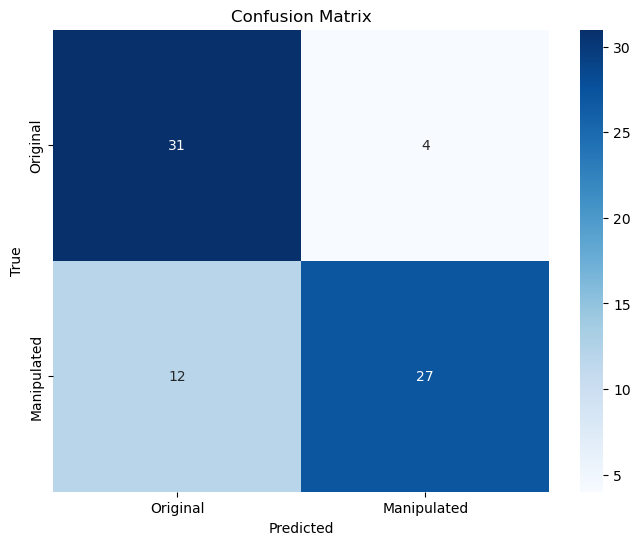

Classification Report:
              precision    recall  f1-score   support

    Original       0.72      0.89      0.79        35
 Manipulated       0.87      0.69      0.77        39

    accuracy                           0.78        74
   macro avg       0.80      0.79      0.78        74
weighted avg       0.80      0.78      0.78        74



In [10]:
import torch
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from torchvision import transforms
from PIL import Image
import os

# Function to load model weights
def load_model(model, model_path, device):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

# Function to evaluate the model on test data
def evaluate_model(model, test_loader, device):
    model.eval()
    y_true, y_pred = [], []
    
    with torch.no_grad():
        for sequences, labels in tqdm(test_loader, desc="Testing"):
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            predictions = outputs.argmax(dim=1).cpu().numpy()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions)
    
    return y_true, y_pred

# Function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# Test Dataset Class
class TestVideoFrameDataset(VideoFrameDataset):
    def __init__(self, data_dir, transform=None, sequence_length=10):
        super().__init__(data_dir, transform, sequence_length)

# Main Script
if __name__ == "__main__":
    # Paths and Hyperparameters
    test_data_dir = "cropped_faces_big/TEST"
    model_path = "models/best_model_epoch_3.pth"  # Adjust path to your model
    sequence_length = 10
    batch_size = 8

    # Device Configuration
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Data Transform for Test Dataset
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Test Dataset and Loader
    test_dataset = TestVideoFrameDataset(data_dir=test_data_dir, transform=transform, sequence_length=sequence_length)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize Model and Load Weights
    model = EfficientNetGRU(sequence_length=sequence_length)
    model = load_model(model, model_path, device)

    # Evaluate Model on Test Data
    y_true, y_pred = evaluate_model(model, test_loader, device)

    # Plot Confusion Matrix
    class_names = ["Original", "Manipulated"]
    plot_confusion_matrix(y_true, y_pred, class_names)

    # Print Classification Report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))


In [4]:
import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Dataset Class for Test Data
class TestDataset(Dataset):
    def __init__(self, data_dir, transform=None, sequence_length=10):
        """
        Args:
            data_dir (str): Directory containing folders of video frames.
            transform (callable, optional): Transform to be applied on frames.
            sequence_length (int): Number of frames per video sequence.
        """
        self.data_dir = data_dir
        self.transform = transform
        self.sequence_length = sequence_length
        self.data = []

        # Load video frame directories
        videos = os.listdir(data_dir)
        for video in videos:
            video_path = os.path.join(data_dir, video)
            frames = sorted(os.listdir(video_path))
            if len(frames) >= sequence_length:
                self.data.append((video_path, frames))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        video_path, frames = self.data[idx]
        sequence = []

        # Select a fixed number of frames
        selected_frames = frames[:self.sequence_length]
        for frame in selected_frames:
            frame_path = os.path.join(video_path, frame)
            image = Image.open(frame_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            sequence.append(image)

        sequence = torch.stack(sequence)
        return sequence, video_path  # Returning video path for identification

# Model Definition
class EfficientNetGRU(nn.Module):
    def __init__(self, sequence_length=10, num_classes=2):
        super(EfficientNetGRU, self).__init__()
        self.sequence_length = sequence_length

        # EfficientNet Backbone
        self.efficientnet = models.efficientnet_b0(pretrained=True)
        self.efficientnet_features = nn.Sequential(
            *list(self.efficientnet.children())[:-2]
        )
        feature_size = self.efficientnet.classifier[1].in_features

        # GRU Layer
        self.gru = nn.GRU(feature_size, hidden_size=128, num_layers=2, batch_first=True, bidirectional=True)

        # Fully Connected Layer
        self.fc = nn.Linear(128 * 2, num_classes)

    def forward(self, x):
        batch_size, seq_len, c, h, w = x.size()
        assert seq_len == self.sequence_length, "Sequence length mismatch!"

        # Extract features frame-by-frame
        features = []
        for i in range(seq_len):
            frame_features = self.efficientnet_features(x[:, i])
            frame_features = frame_features.mean([2, 3])  # Global average pooling
            features.append(frame_features)

        features = torch.stack(features, dim=1)

        # GRU processing
        _, hidden = self.gru(features)
        hidden = torch.cat([hidden[-2], hidden[-1]], dim=1)

        # Classification
        output = self.fc(hidden)
        return output

# Load Model
def load_model(model, model_path, device):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

# Predict on Test Data
def predict_on_test(model, test_loader, device, class_names):
    model.eval()
    predictions = {}

    with torch.no_grad():
        for sequences, video_paths in tqdm(test_loader, desc="Predicting"):
            sequences = sequences.to(device)
            outputs = model(sequences)
            pred_labels = outputs.argmax(dim=1).cpu().numpy()

            for video_path, pred_label in zip(video_paths, pred_labels):
                predictions[video_path] = class_names[pred_label]

    return predictions

# Plot Confusion Matrix (Optional if labels are available)
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# Main Script
if __name__ == "__main__":
    # Test Dataset Directory
    test_data_dir = "cropped_faces_big/TEST"

    # Sequence length and batch size
    sequence_length = 10
    batch_size = 8

    # Model path
    model_path = "models/best_model_epoch_3.pth"  # Update with your saved model path

    # Device configuration
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Class names
    class_names = ["Original", "Manipulated"]

    # Test Data Loader
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    test_dataset = TestDataset(data_dir=test_data_dir, transform=transform, sequence_length=sequence_length)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Load the model
    model = EfficientNetGRU(sequence_length=sequence_length)
    model = load_model(model, model_path, device)

    # Predict on test data
    predictions = predict_on_test(model, test_loader, device, class_names)

    # Display predictions
    for video_path, label in predictions.items():
        print(f"Video: {video_path}, Prediction: {label}")


C:\Enviroment\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Enviroment\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\temp\ipykernel_13484\2470730644.py:95: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrust

Video: cropped_faces_big/TEST\00000, Prediction: Original
Video: cropped_faces_big/TEST\00004, Prediction: Original
Video: cropped_faces_big/TEST\00007, Prediction: Original
Video: cropped_faces_big/TEST\01_02__meeting_serious__YVGY8LOK, Prediction: Manipulated
Video: cropped_faces_big/TEST\01_11__talking_against_wall__UQ0BOBNO, Prediction: Manipulated
Video: cropped_faces_big/TEST\01_15__meeting_serious__02HILKYO, Prediction: Manipulated
Video: cropped_faces_big/TEST\01_15__outside_talking_still_laughing__02HILKYO, Prediction: Manipulated
Video: cropped_faces_big/TEST\01_20__hugging_happy__6UBMLXK3, Prediction: Manipulated
Video: cropped_faces_big/TEST\01_20__talking_angry_couch__6UBMLXK3, Prediction: Manipulated
Video: cropped_faces_big/TEST\01__kitchen_pan, Prediction: Original
Video: cropped_faces_big/TEST\01__meeting_serious, Prediction: Original
Video: cropped_faces_big/TEST\01__outside_talking_pan_laughing, Prediction: Original
Video: cropped_faces_big/TEST\01__podium_speech_hap

In [3]:
import os
import random
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

# Define Dataset Class
class VideoFrameDataset(Dataset):
    def __init__(self, data_dir, transform=None, sequence_length=10):
        """
        Args:
            data_dir (str): Directory containing 'real' and 'fake' subdirectories with images.
            transform (callable, optional): Transform to be applied on frames.
            sequence_length (int): Number of frames per video sequence.
        """
        self.data_dir = data_dir
        self.transform = transform
        self.sequence_length = sequence_length
        self.classes = {"real": 0, "fake": 1}
        self.data = []

        for cls, label in self.classes.items():
            cls_path = os.path.join(data_dir, cls)
            images = sorted(os.listdir(cls_path))
            # Group images into sequences
            for i in range(0, len(images) - sequence_length + 1):
                sequence = images[i:i + sequence_length]
                self.data.append((cls_path, label, sequence))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        cls_path, label, frames = self.data[idx]
        sequence = []

        for frame in frames:
            frame_path = os.path.join(cls_path, frame)
            image = Image.open(frame_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            sequence.append(image)

        sequence = torch.stack(sequence)
        return sequence, label


# Data Loading and Splitting
def get_data_loaders(data_dir, sequence_length=10, batch_size=8, val_split=0.2):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    dataset = VideoFrameDataset(data_dir=data_dir, transform=transform, sequence_length=sequence_length)

    val_size = int(len(dataset) * val_split)
    train_size = len(dataset) - val_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

# Model Definition
class EfficientNetGRU(nn.Module):
    def __init__(self, sequence_length=10, num_classes=2):
        super(EfficientNetGRU, self).__init__()
        self.sequence_length = sequence_length

        # EfficientNet Backbone
        self.efficientnet = models.efficientnet_b0(pretrained=True)
        self.efficientnet_features = nn.Sequential(
            *list(self.efficientnet.children())[:-2]
        )
        feature_size = self.efficientnet.classifier[1].in_features

        # GRU Layer
        self.gru = nn.GRU(feature_size, hidden_size=128, num_layers=2, batch_first=True, bidirectional=True)

        # Fully Connected Layer
        self.fc = nn.Linear(128 * 2, num_classes)

    def forward(self, x):
        batch_size, seq_len, c, h, w = x.size()
        assert seq_len == self.sequence_length, "Sequence length mismatch!"

        # Extract features frame-by-frame
        features = []
        for i in range(seq_len):
            frame_features = self.efficientnet_features(x[:, i])
            frame_features = frame_features.mean([2, 3])  # Global average pooling
            features.append(frame_features)

        features = torch.stack(features, dim=1)

        # GRU processing
        _, hidden = self.gru(features)
        hidden = torch.cat([hidden[-2], hidden[-1]], dim=1)

        # Classification
        output = self.fc(hidden)
        return output

# Training Loop
def train_model(model, train_loader, criterion, optimizer, num_epochs, device):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        y_true, y_pred = [], []

        for sequences, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):
            sequences, labels = sequences.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(outputs.argmax(dim=1).cpu().numpy())

        train_acc = accuracy_score(y_true, y_pred)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}, Accuracy: {train_acc:.4f}")

# Evaluation Loop
def evaluate_model(model, val_loader, device):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for sequences, labels in tqdm(val_loader, desc="Validation"):
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(outputs.argmax(dim=1).cpu().numpy())

    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=["real", "fake"]))

# Main Script
if __name__ == "__main__":
    # Hyperparameters
    sequence_length = 10
    batch_size = 8
    num_epochs = 5
    learning_rate = 1e-4
    val_split = 0.2

    # Dataset directory (contains 'original' and 'manipulated' subfolders)
    data_dir = "Dataset/Train"

    # Device Configuration
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Get Data Loaders
    train_loader, val_loader = get_data_loaders(data_dir, sequence_length=sequence_length, batch_size=batch_size, val_split=val_split)

    # Initialize Model, Criterion, Optimizer
    model = EfficientNetGRU(sequence_length=sequence_length)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train and Evaluate
    train_model(model, train_loader, criterion, optimizer, num_epochs, device)
    evaluate_model(model, val_loader, device)


C:\Enviroment\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Enviroment\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1:   0%|          | 1/13999 [02:20<545:47:37, 140.37s/it]

KeyboardInterrupt

